<a href="https://colab.research.google.com/github/prometheus404/AMD_project/blob/filtering-test/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##### DOWNLOAD DATASET #####
from IPython.display import clear_output
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gsimonx37/letterboxd
!unzip /content/letterboxd.zip -d /content/letterbox/
clear_output()
############################

In [2]:
########### SPARK CONTEXT #####################
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

sc = spark.sparkContext
###############################################

In [3]:
import pandas as pd
import itertools
from tqdm import tqdm
import time

In [3]:
N_BASKETS = 30000       #0 for full dataset
SPARK_CREATION = False  #initialize the RDD using spark instead of pandas to read the file

############## BASKET CREATION ################
if(SPARK_CREATION == False):
  actors = pd.read_csv("letterbox/actors.csv")
  actors = actors
  baskets = actors.groupby("id")["name"].apply(list)
  if(N_BASKETS > 0):
    baskets = baskets.sample(N_BASKETS, random_state = 42)

  print("number of baskets: " + str(len(baskets)))
  print("biggest basket: " + str(baskets.map(len).max()))
  print(baskets)
  baskets_RDD = sc.parallelize(baskets).cache()
  n_baskets = len(baskets)
else:
  RDD = sc.textFile("letterbox/actors.csv").map(lambda x: tuple(x.split(',')[:2])) #read from csv and split
  RDD = RDD.filter(lambda x: x != ('id','name')) #filter out the header
  RDD = RDD.groupByKey().mapValues(list).values()
  if(N_BASKETS > 0):
    baskets_RDD = RDD.sample(False, N_BASKETS/RDD.count(), seed = 42).cache() #fixed but different for each iteration seed
  else:
    baskets_RDD = RDD.cache()
  n_baskets = baskets_RDD.count()
print(n_baskets)
##############################################

number of baskets: 30000
biggest basket: 186
id
1850862                                   [Friedhelm Funkel]
1189772    [Derek Jacobi, Kenneth Branagh, Richard Easton...
1139390    [Dawn Murphy, Tina Krause, Gary Whitson, Deana...
1645732                                          [Jake Ryan]
1234913    [Nicoll Bacharach, Patrick B. Johnson, Robert ...
                                 ...                        
1292298    [Cassidy Brown, Benjamin Lee Estavan, Maya Gil...
1601992    [Lil Dagover, Eugen Burg, Boris de Fast, Jaro ...
1096738    [Reid Doyle, Cari Moskow, Donny Boaz, Devin Mc...
1058318    [Mikael Persbrandt, Saba Mubarak, Jason Flemyn...
1725927                           [Oh Eun-jae, Ha Young-joo]
Name: name, Length: 30000, dtype: object
30000


In [41]:
## APRIORI
def apriori2(chunk, s, tot_bsk):

  n_bsk = 0 # number of baskets in chunk used to calculate support
#  trsl = dict() # using a translation could be better for the combination step
  count = dict() # should be relatively efficient since is a hash table

  def incr(e,dic):
    if e in dic:
      dic[e] += 1;
    else:
      dic[e] = 1

  chunk = list(chunk) # to avoid consuming after first pass
  ### first pass
  for bsk in chunk:
    n_bsk += 1;
    #elements = [translate(x,trsl) for x in bsk]
    for b in bsk:
      incr(b,count)

  ### filter
  frequent = []
  for c in count:
    if count[c] >= s* n_bsk/tot_bsk:
      frequent.append(c)

  count = dict()
  for bsk in tqdm(chunk):
    #filter only members of C_2
    bsk = [x for x in bsk if x in frequent]
    bsk.sort()
    tpl = list(itertools.combinations(bsk, 2))
    for t in tpl:
      incr(t,count)
  # construct members of L_2
  frequent = []
  print(len(count))
  for c in count:
    if count[c] >= s * n_bsk/tot_bsk:
      frequent.append(c)
      yield(c,1)

  k = 3
  while len(frequent) > 0:
    #break
    count = dict()
    freq_candidates = []

    for i in range(len(frequent)-1):
      for j in range(i + 1, len(frequent)):
        if(frequent[i][:k - 2] == frequent[j][:k - 2]):
          x = list(frequent[i] + frequent[j][k - 2:])
          x.sort()
          #print(x)
          freq_candidates.append(tuple(x))

    if(len(freq_candidates) == 0):
      break

    count = {t:0 for t in freq_candidates}

    for bsk in tqdm(chunk):
      #filter only members of C_k
      bsk.sort()
      for t in itertools.combinations(bsk, k):
        if(t in count):
          count[t] += 1
    # construct members of L_k
    frequent = []
    print(len(count))
    for c in count:
      if count[c] >= s * n_bsk/tot_bsk:
        frequent.append(c)
        yield(c,1)
    k+=1

In [4]:
## APRIORI
def apriori(chunk, s, tot_bsk):

  n_bsk = 0 # number of baskets in chunk used to calculate support
  count = dict() # should be relatively efficient since is a hash table

  def incr(e,dic):
    if e in dic:
      dic[e] += 1;
    else:
      dic[e] = 1

  chunk = list(chunk) # to avoid consuming after first pass
  ### first pass
  for bsk in chunk:
    n_bsk += 1;
    #elements = [translate(x,trsl) for x in bsk]
    for b in bsk:
      incr(b,count)

  ### filter
  frequent = []
  for c in count:
    if count[c] >= s* n_bsk/tot_bsk:
      frequent.append(c)

  count = dict()
  for bsk in tqdm(chunk):
    #filter only members of C_2
    bsk = [x for x in bsk if x in frequent]
    bsk.sort()
    tpl = list(itertools.combinations(bsk, 2))
    for t in tpl:
      incr(t,count)
  # construct members of L_2
  frequent = []
  print(len(count))
  for c in count:
    if count[c] >= s * n_bsk/tot_bsk:
      frequent.append(c)
      yield(c,1)

  k = 3
  while len(frequent) > 0:
    #break
    count = dict()
    freq_candidates = []

    for i in range(len(frequent)-1):
      for j in range(i + 1, len(frequent)):
        if(frequent[i][:k - 2] == frequent[j][:k - 2]):
          x = list(frequent[i] + frequent[j][k - 2:])
          x.sort()
          #print(x)
          freq_candidates.append(tuple(x))

    if(len(freq_candidates) == 0):
      break

    count = {t:0 for t in freq_candidates}

    for bsk in tqdm(chunk):
      #filter only members of C_k
      filtered = set()
      for b in bsk:
        for f in frequent:
          if b in f:
            filtered.add(b)
            break;
      bsk = list(filtered)
      bsk.sort()
      for t in itertools.combinations(bsk, k):
        if(t in count):
          count[t] += 1
    # construct members of L_k
    frequent = []
    print(len(count))
    for c in count:
      if count[c] >= s * n_bsk/tot_bsk:
        frequent.append(c)
        yield(c,1)
    k+=1

In [43]:
tmp = [['a','b','c'],
 ['a','b','c'],
 ['a','b','c'],
 ['a','b','c'],
 ['a','b','f'],
 ['a','b','f'],
 ['l','f'],
 ['l','f']]
for i in apriori(tmp,2,8):
  print(i)

100%|██████████| 8/8 [00:00<00:00, 46345.90it/s]


6
(('a', 'b'), 1)
(('a', 'c'), 1)
(('b', 'c'), 1)
(('a', 'f'), 1)
(('b', 'f'), 1)
(('f', 'l'), 1)


100%|██████████| 8/8 [00:00<00:00, 48559.24it/s]


4
(('a', 'b', 'c'), 1)
(('a', 'b', 'f'), 1)


100%|██████████| 8/8 [00:00<00:00, 43747.63it/s]

1


In [5]:
## SON
def son(rdd,s,tot):
  def chunk_support(chunk,itemset):
    def incr(e,dic):
      try:
        dic[e] += 1;
      except KeyError:
        dic[e] = 1

    count = dict()
    for bsk in tqdm(chunk):
      for i in itemset:
        flag = True
        for e in i:
          if e not in bsk:
            flag = False
            break
        if flag:
          incr(i,count)
    for c in count:
      yield (c,count[c])

  t= time.time()
  #FIRST STEP
  candidates = rdd.mapPartitions(lambda x: apriori(x,s,tot)).reduceByKey(lambda a,b: a).keys().collect()
  #SECOND STEP
  out =  rdd.mapPartitions(lambda x: chunk_support(x, candidates)).reduceByKey(lambda a,b: a+b).filter(lambda a: a[1] >= s).keys().collect()
  t = time.time() - t
  return (t,out)


In [46]:
son(baskets_RDD, 6, n_baskets)

(115.33737301826477,
 [('Charlie Hall', 'Stan Laurel'),
  ('Hideo Murota', 'Rinichi Yamamoto'),
  ('Ken Takakura', 'Rinichi Yamamoto'),
  ('Nobuko Otowa', 'Taiji Tonoyama'),
  ('Adoor Bhasi', 'Prem Nazir'),
  ('Fernando Poe Jr.', 'Vic Varrion'),
  ('Russi Taylor', 'Tony Anselmo'),
  ('James Hetfield', 'Kirk Hammett'),
  ('James Hetfield', 'Lars Ulrich'),
  ('Kirk Hammett', 'Lars Ulrich'),
  ('František Kreuzmann', 'Vladimír Řepa'),
  ('Mel Blanc', 'Sara Berner'),
  ('George Harrison', 'Paul McCartney'),
  ('George Harrison', 'John Lennon'),
  ('George Harrison', 'Paul McCartney', 'Ringo Starr'),
  ('Ramana Maharshi', 'Sri Michael James'),
  ('Arthur Q. Bryan', 'Mel Blanc'),
  ('Adoor Bhasi', 'Sukumari'),
  ('Sammo Hung', 'Yuen Biao'),
  ('Josef Hlinomaz', 'Miroslav Homola'),
  ('Jack Mercer', 'Jackson Beck'),
  ('Jack Mercer', 'Mae Questel'),
  ('Jackson Beck', 'Mae Questel'),
  ('Brian May', 'John Deacon'),
  ('Brian May', 'Roger Taylor'),
  ('John Deacon', 'Roger Taylor'),
  ('Brian 

In [8]:
## APRIORI
def apriori_old(chunk, s, tot_bsk):


  n_bsk = 0 # number of baskets in chunk used to calculate support
#  trsl = dict() # using a translation could be better for the combination step
  count = dict() # should be relatively efficient since is a hash table

#
#  def translate(e, dic):
#    try:
#      return dic[e]
#    except KeyError:
#      dic[e] = len(dic)+1
#      return dic[e]
  def incr(e,dic):
    try:
      dic[e] += 1;
    except KeyError:
      dic[e] = 1

  chunk = list(chunk) # to avoid consuming after first pass
  ### first pass
  for bsk in chunk:
    n_bsk += 1;
    #elements = [translate(x,trsl) for x in bsk]
    for b in bsk:
      incr(b,count)

  ### filter
  to_del = []
  frequent = []
  for c in count:
    if count[c] >= s* n_bsk/tot_bsk:
      frequent.append(c)

  k = 2
  while len(frequent) > 0:
    count = dict()

    for bsk in tqdm(chunk):
      #filter only members of C_k
      filtered = set()
      for b in bsk:
        for f in frequent:
          if k== 2 and b == f:
            filtered.add(b)
            break;
          if k > 2 and b in f:
          #if b in f:
            filtered.add(b)
            break;
      bsk = list(filtered)
      bsk.sort()
      for tpl in itertools.combinations(bsk, k):
          incr(tuple(tpl), count)

    frequent = []
    for c in count:
      if count[c] >= s * n_bsk/tot_bsk:
        frequent.append(c)
        yield(c,1)
    k+=1

In [44]:
for a in apriori(baskets,6,n_baskets):
  print(a)

100%|██████████| 30000/30000 [01:03<00:00, 473.04it/s]


43557
(('František Kreuzmann', 'Rudolf Hrušínský'), 1)
(('Jagathy Sreekumar', 'Nedumudi Venu'), 1)
(('Hashizo Okawa', 'Shin Tokudaiji'), 1)
(('Larry Fine', 'Moe Howard'), 1)
(('Gene Simmons', 'Paul Stanley'), 1)
(('Charlie Hall', 'Stan Laurel'), 1)
(('Oliver Hardy', 'Stan Laurel'), 1)
(('Hideo Murota', 'Rinichi Yamamoto'), 1)
(('Ken Takakura', 'Rinichi Yamamoto'), 1)
(('Nobuko Otowa', 'Taiji Tonoyama'), 1)
(('Adoor Bhasi', 'Sheela'), 1)
(('Adoor Bhasi', 'Prem Nazir'), 1)
(('Prem Nazir', 'Sheela'), 1)
(('Dave Goelz', 'Steve Whitmire'), 1)
(('Fernando Poe Jr.', 'Paquito Diaz'), 1)
(('Fernando Poe Jr.', 'Vic Varrion'), 1)
(('Paquito Diaz', 'Vic Varrion'), 1)
(('Russi Taylor', 'Tony Anselmo'), 1)
(('James Hetfield', 'Kirk Hammett'), 1)
(('James Hetfield', 'Lars Ulrich'), 1)
(('Kirk Hammett', 'Lars Ulrich'), 1)
(('František Kreuzmann', 'Vladimír Řepa'), 1)
(('Amanda Day', 'Amanda Day'), 1)
(('Mel Blanc', 'Sara Berner'), 1)
(('Eitarō Shindō', 'Haruo Tanaka'), 1)
(('Jun Fujikawa', 'Saburo Dat

100%|██████████| 30000/30000 [00:07<00:00, 3765.66it/s]


35
(('Fernando Poe Jr.', 'Paquito Diaz', 'Vic Varrion'), 1)
(('James Hetfield', 'Kirk Hammett', 'Lars Ulrich'), 1)
(('George Harrison', 'Paul McCartney', 'Ringo Starr'), 1)
(('Jack Mercer', 'Jackson Beck', 'Mae Questel'), 1)
(('Brian May', 'Freddie Mercury', 'John Deacon'), 1)
(('Brian May', 'Freddie Mercury', 'Roger Taylor'), 1)
(('Brian May', 'John Deacon', 'Roger Taylor'), 1)
(('Freddie Mercury', 'John Deacon', 'Roger Taylor'), 1)


100%|██████████| 30000/30000 [00:01<00:00, 22274.08it/s]


1
(('Brian May', 'Freddie Mercury', 'John Deacon', 'Roger Taylor'), 1)


In [13]:
for a in apriori_old(baskets,6,n_baskets):
  print(a)

100%|██████████| 30000/30000 [02:29<00:00, 200.37it/s]


(('Jagathy Sreekumar', 'Nedumudi Venu'), 1)
(('Hashizo Okawa', 'Shin Tokudaiji'), 1)
(('Larry Fine', 'Moe Howard'), 1)
(('Gene Simmons', 'Paul Stanley'), 1)
(('Charlie Hall', 'Stan Laurel'), 1)
(('Oliver Hardy', 'Stan Laurel'), 1)
(('Hideo Murota', 'Rinichi Yamamoto'), 1)
(('Ken Takakura', 'Rinichi Yamamoto'), 1)
(('Nobuko Otowa', 'Taiji Tonoyama'), 1)
(('Adoor Bhasi', 'Sheela'), 1)
(('Adoor Bhasi', 'Prem Nazir'), 1)
(('Prem Nazir', 'Sheela'), 1)
(('Dave Goelz', 'Steve Whitmire'), 1)
(('Fernando Poe Jr.', 'Paquito Diaz'), 1)
(('Fernando Poe Jr.', 'Vic Varrion'), 1)
(('Paquito Diaz', 'Vic Varrion'), 1)
(('Russi Taylor', 'Tony Anselmo'), 1)
(('James Hetfield', 'Kirk Hammett'), 1)
(('James Hetfield', 'Lars Ulrich'), 1)
(('Kirk Hammett', 'Lars Ulrich'), 1)
(('František Kreuzmann', 'Vladimír Řepa'), 1)
(('Mel Blanc', 'Sara Berner'), 1)
(('Eitarō Shindō', 'Haruo Tanaka'), 1)
(('Jun Fujikawa', 'Saburo Date'), 1)
(('Innocent', 'KPAC Lalitha'), 1)
(('George Harrison', 'John Lennon'), 1)
(('Geor

100%|██████████| 30000/30000 [00:02<00:00, 14276.55it/s]


(('Fernando Poe Jr.', 'Paquito Diaz', 'Vic Varrion'), 1)
(('James Hetfield', 'Kirk Hammett', 'Lars Ulrich'), 1)
(('George Harrison', 'Paul McCartney', 'Ringo Starr'), 1)
(('Jack Mercer', 'Jackson Beck', 'Mae Questel'), 1)
(('Brian May', 'Freddie Mercury', 'John Deacon'), 1)
(('Brian May', 'Freddie Mercury', 'Roger Taylor'), 1)
(('Brian May', 'John Deacon', 'Roger Taylor'), 1)
(('Freddie Mercury', 'John Deacon', 'Roger Taylor'), 1)


100%|██████████| 30000/30000 [00:00<00:00, 74226.19it/s]


(('Brian May', 'Freddie Mercury', 'John Deacon', 'Roger Taylor'), 1)


100%|██████████| 30000/30000 [00:00<00:00, 178448.88it/s]


In [ ]:
# NOTE it's important to change seed even with different fractions
# tmp2 = sc.parallelize(range(0,1000))
# print(tmp2.sample(False,fraction=0.001, seed = 42).collect()) # output: [115,385]
# print(tmp2.sample(False,fraction=0.002, seed = 42).collect()) # output: [115, 359, 385]
# print(tmp2.sample(False,fraction=0.003, seed = 42).collect()) # output: [115, 359, 385]

[115, 385]
[115, 359, 385]
[115, 359, 385]


In [ ]:
#RDD = sc.textFile("letterbox/actors.csv").map(lambda x: tuple(x.split(','))) #read from csv and split
#RDD = RDD.filter(lambda x: x != ('id','name')) #filter out the header
##construct dictionary for translation
#RDD_dict = RDD.sortBy(lambda x: x[1]).values().distinct().zipWithIndex() # not zipWithUniquenId since we could need gap-less id
#RDD = RDD.map(lambda x: (x[1],x[0])) #invert keys with values in order to perform the join over the actor name
#RDD = RDD.join(RDD_dict).map(lambda x: (x[1][0],x[1][1])) #join and use as key the movie and as value the actor id
#RDD = RDD.groupByKey().mapValues(list).values().cache() #create the baskets and cache them

##sample RDD and save the results
#for i in tqdm(range(10000, 60000, 10000)):
#  sampled_RDD = RDD.takeSample(False, i, seed = i) #fixed but different for each iteration seed
#  #sampled_RDD.saveAsTextFile("./rdd-"+str(i)+".csv")
#  print(son(sampled_RDD,15,sampled_RDD.count()))
#recover from memory
#for i in tqdm(range(10000,60000,10000)):
#  x = sc.textFile("rdd-"+str(i)+".csv/")
#  x = x.map(lambda s: s[1:-1].split(',')).map(lambda s: [int(i) for i in s])
#  son(x,6,i)

# Time and different dataset size

In [10]:
actors = pd.read_csv("letterbox/actors.csv")
actors = actors
baskets_full = actors.groupby("id")["name"].apply(list)
r = range(1,11)
S = 6
step = 3500

In [11]:
#TIME WITH DIFFERENT DATASET SIZE APRIORI
apriori_results = []
apriori_times = []
for i in r:
  baskets = baskets_full.sample(i*step, random_state = i)
  #RDD = sc.parallelize(baskets)
  result = []
  t = time.time()
  for i,_ in apriori(baskets,S,i*step):
    result.append(i)
  apriori_times.append(time.time()-t)
  apriori_results.append(result)

100%|██████████| 3500/3500 [00:00<00:00, 184959.67it/s]


1


100%|██████████| 7000/7000 [00:00<00:00, 60399.48it/s]


45


100%|██████████| 10500/10500 [00:00<00:00, 14455.39it/s]


973


100%|██████████| 14000/14000 [00:01<00:00, 8296.72it/s]


2103


100%|██████████| 14000/14000 [00:00<00:00, 29233.24it/s]


10


100%|██████████| 14000/14000 [00:00<00:00, 30651.52it/s]


5


100%|██████████| 14000/14000 [00:00<00:00, 50380.13it/s]


1


100%|██████████| 17500/17500 [00:04<00:00, 3818.58it/s]


5929


100%|██████████| 17500/17500 [00:01<00:00, 15417.18it/s]


4


100%|██████████| 17500/17500 [00:00<00:00, 34555.12it/s]


1


100%|██████████| 21000/21000 [00:21<00:00, 976.49it/s]


14889


100%|██████████| 21000/21000 [00:02<00:00, 7342.05it/s]


34


100%|██████████| 21000/21000 [00:01<00:00, 13099.94it/s]


16


100%|██████████| 21000/21000 [00:01<00:00, 19621.81it/s]


6


100%|██████████| 21000/21000 [00:00<00:00, 40609.76it/s]


1


100%|██████████| 24500/24500 [00:26<00:00, 929.40it/s]


23945


100%|██████████| 24500/24500 [00:04<00:00, 5713.55it/s]


21


100%|██████████| 24500/24500 [00:01<00:00, 19938.18it/s]


5


100%|██████████| 24500/24500 [00:00<00:00, 53432.68it/s]


1


100%|██████████| 28000/28000 [00:46<00:00, 597.91it/s]


35517


100%|██████████| 28000/28000 [00:05<00:00, 5116.93it/s]


44


100%|██████████| 28000/28000 [00:01<00:00, 16367.60it/s]


7


100%|██████████| 28000/28000 [00:00<00:00, 39182.57it/s]


1


100%|██████████| 31500/31500 [01:26<00:00, 366.03it/s]


66653


100%|██████████| 31500/31500 [00:13<00:00, 2268.68it/s]


67


100%|██████████| 31500/31500 [00:01<00:00, 22935.71it/s]


2


100%|██████████| 35000/35000 [01:49<00:00, 319.64it/s]


83739


100%|██████████| 35000/35000 [00:18<00:00, 1845.08it/s]


91


100%|██████████| 35000/35000 [00:11<00:00, 3046.25it/s]


47


100%|██████████| 35000/35000 [00:06<00:00, 5170.66it/s]


22


100%|██████████| 35000/35000 [00:02<00:00, 13558.46it/s]


7


100%|██████████| 35000/35000 [00:01<00:00, 33829.88it/s]

1


In [12]:
# TIME WITH DIFFERENT DATASET SIZE SON
son_results = []
son_times = []
for i in r:
  print(i*step)
  baskets = baskets_full.sample(i*step, random_state = i)
  RDD = sc.parallelize(baskets)
  t, result = son(RDD,S,i*step)
  son_results.append(result)
  son_times.append(t)

3500
7000
10500
14000
17500
21000
24500
28000
31500
35000


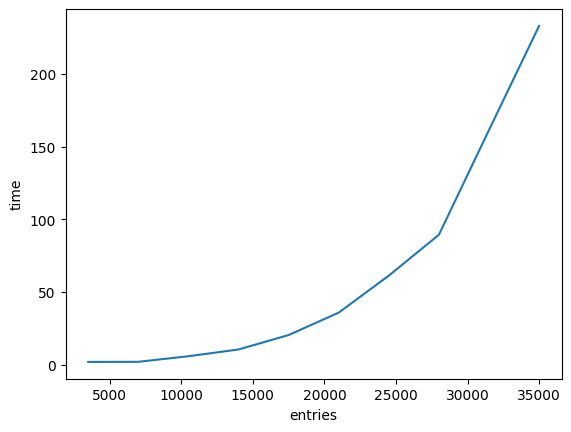

In [13]:
import matplotlib.pyplot as plt
#plt.plot(list([step*x for x in r]), apriori_times)
plt.plot(list([step*x for x in r]), son_times)
#plt.legend(['apriori','SON'])
plt.ylabel('time')
plt.xlabel('entries')
plt.show()

In [14]:
# NUMBER OF FREQUENT ITEMSETS FOR EACH SIZE
def itemset_size(itemsets):
  out = []
  for s in itemsets:
    tmp = []
    for i in range(2,8):
      n = len([x for x in s if len(x) == i])
      if n == 0:
        break
      tmp.append((i,n))
    out.append(tmp)
  return out

sz = itemset_size(apriori_results)
for i in r:
  print('size ' + str(i * step) + ': ')
  for e in sz[i-1]:
    print(str(e[0])+'-ples: ' + str(e[1]))

size 3500: 
size 7000: 
size 10500: 
size 14000: 
2-ples: 12
3-ples: 10
4-ples: 5
5-ples: 1
size 17500: 
2-ples: 15
3-ples: 4
4-ples: 1
size 21000: 
2-ples: 50
3-ples: 28
4-ples: 16
5-ples: 6
6-ples: 1
size 24500: 
2-ples: 40
3-ples: 11
4-ples: 5
5-ples: 1
size 28000: 
2-ples: 80
3-ples: 21
4-ples: 7
5-ples: 1
size 31500: 
2-ples: 126
3-ples: 14
4-ples: 2
size 35000: 
2-ples: 132
3-ples: 71
4-ples: 45
5-ples: 22
6-ples: 7
7-ples: 1


In [15]:
print(apriori_times)
print(son_times)

[0.7789347171783447, 0.21815776824951172, 0.8783605098724365, 3.161717414855957, 6.497379541397095, 28.187054872512817, 32.74188494682312, 55.16551446914673, 101.83974170684814, 150.98118209838867]
[1.987138271331787, 2.060698986053467, 5.90418553352356, 10.529363870620728, 20.474119663238525, 35.86480474472046, 61.30871367454529, 89.39835906028748, 161.42316961288452, 232.95110845565796]


# Time and different suppord threshold

In [53]:
r = 100000
S = range(10,30,3)
step = 5000
baskets = baskets_full.sample(r, random_state = 42)

In [54]:
#TIME WITH DIFFERENT DATASET SUPPORT THRESHOLD APRIORI
apriori_results = []
apriori_times = []
for s in S:
  result = []
  t = time.time()
  for i,_ in apriori(baskets,s,r):
    result.append(i)
  apriori_times.append(time.time()-t)
  apriori_results.append(result)

100%|██████████| 100000/100000 [14:45<00:00, 112.89it/s]


455295


100%|██████████| 100000/100000 [02:08<00:00, 775.68it/s]


447


100%|██████████| 100000/100000 [00:35<00:00, 2800.57it/s]


61


100%|██████████| 100000/100000 [00:24<00:00, 4144.49it/s]


28


100%|██████████| 100000/100000 [00:12<00:00, 8252.12it/s]


8


100%|██████████| 100000/100000 [00:05<00:00, 18000.43it/s]


1


100%|██████████| 100000/100000 [07:54<00:00, 210.88it/s]


246613


100%|██████████| 100000/100000 [00:36<00:00, 2714.37it/s]


108


100%|██████████| 100000/100000 [00:19<00:00, 5073.99it/s]


41


100%|██████████| 100000/100000 [00:18<00:00, 5362.20it/s]


22


100%|██████████| 100000/100000 [00:07<00:00, 13172.69it/s]


7


100%|██████████| 100000/100000 [00:03<00:00, 28934.99it/s]


1


100%|██████████| 100000/100000 [04:12<00:00, 395.38it/s]


134223


100%|██████████| 100000/100000 [00:19<00:00, 5114.71it/s]


22


100%|██████████| 100000/100000 [00:03<00:00, 26043.11it/s]


2


100%|██████████| 100000/100000 [02:16<00:00, 733.43it/s]


72351


100%|██████████| 100000/100000 [00:04<00:00, 21735.72it/s]


4


100%|██████████| 100000/100000 [01:12<00:00, 1388.38it/s]


38962


100%|██████████| 100000/100000 [00:03<00:00, 25843.32it/s]


3


100%|██████████| 100000/100000 [00:43<00:00, 2299.52it/s]


22004


100%|██████████| 100000/100000 [00:02<00:00, 41731.47it/s]


1


100%|██████████| 100000/100000 [00:26<00:00, 3807.40it/s]


12157


In [55]:
# TIME WITH DIFFERENT DATASET SUPPORT THRESHOLD SON
son_results = []
son_times = []
RDD = sc.parallelize(baskets)
for s in S:
  t, result = son(RDD,s,r)
  son_results.append(result)
  son_times.append(t)

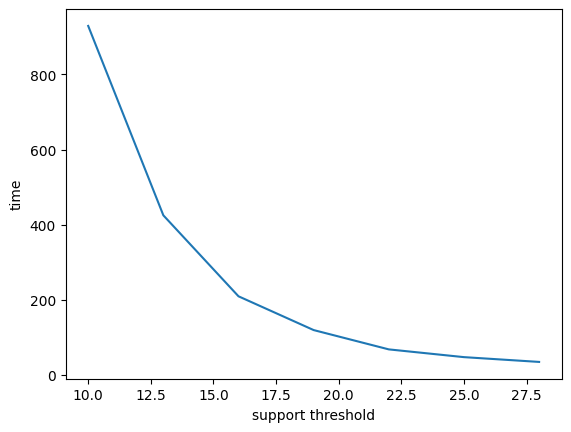

In [56]:
#plt.plot(list(S), apriori_times)
plt.plot(list(S), son_times)
#plt.legend(['apriori','SON'])
plt.ylabel('time')
plt.xlabel('support threshold')
plt.show()

# Time and different partition number

In [71]:
r = 80000
S = 25
baskets = baskets_full.sample(r, random_state = 42)

tp_results = []
tp_times = []
partitions = range(1,6)
for p in partitions:
  spark = SparkSession.builder.master("local["+str(p)+"]").getOrCreate()
  spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
  sc = spark.sparkContext
  RDD = sc.parallelize(baskets)
  t, result = son(RDD,S,r)
  tp_results.append(result)
  tp_times.append(t)



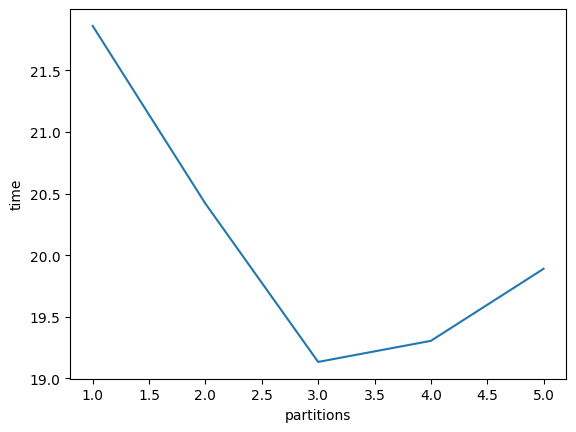

In [72]:
plt.plot(list(partitions), tp_times)
plt.ylabel('time')
plt.xlabel('partitions')
plt.show()